In [121]:
import requests
import pandas as pd
import plotly.express as px

In [158]:
# Base URL
url = "https://data.ny.gov/resource/kh8p-hcbm.json"

# Query parameters (optional)
params = {
    "$limit": 1000000,        # how many rows to fetch
    "$offset": 0,          # for pagination
    # "$select": "col1, col2, col3",  # only necessary columns
    # "$where": "some_column = 'some_value'",  # filtering
}

# Make the request
response = requests.get(url, params=params)

if response.status_code == 200:
    data = response.json()
    df = pd.DataFrame(data)
else:
    print("Request failed with status:", response.status_code)


In [138]:
df.head()

,violation_id,vehicle_id,first_occurrence,last_occurrence,violation_status,violation_type,bus_route_id,violation_latitude,violation_longitude,stop_id,stop_name,bus_stop_latitude,bus_stop_longitude,violation_georeference,bus_stop_georeference
0,489749182,c5ae1411153b52556a1e648cc80d718aa519a4bdd189ab...,2025-08-20T23:12:08.000,2025-08-21T00:24:08.000,TECHNICAL ISSUE/OTHER,MOBILE BUS STOP,BX36,40.840509,-73.881189,102498,EAST TREMONT AV/VYSE AV,40.841076,-73.882483,"{'type': 'Point', 'coordinates': [-73.881189, ...","{'type': 'Point', 'coordinates': [-73.882483, ..."
1,489744714,df9044acf85cf55488aea4cd3ce1d0e17ef050551726b6...,2025-08-20T23:48:59.000,2025-08-20T23:54:47.000,EXEMPT - BUS/PARATRANSIT,MOBILE BUS STOP,BX28,40.874017,-73.890646,100080,PAUL AV/BEDFORD PARK BLVD,40.874629,-73.891539,"{'type': 'Point', 'coordinates': [-73.890646, ...","{'type': 'Point', 'coordinates': [-73.891539, ..."
2,489743631,eb5a337966ba65f66ab1db8e169d2446a4fb429b0efc63...,2025-08-20T22:33:13.000,2025-08-20T23:56:02.000,TECHNICAL ISSUE/OTHER,MOBILE DOUBLE PARKED,Q53+,40.721971,-73.867136,550473,WOODHAVEN BLVD/PENELOPE AV,40.722487,-73.867736,"{'type': 'Point', 'coordinates': [-73.867136, ...","{'type': 'Point', 'coordinates': [-73.867736, ..."
3,489741945,3f877f70d9b253515a945be807c9c62d5814949f810310...,2025-08-20T22:50:45.000,2025-08-20T23:32:43.000,EXEMPT - OTHER,MOBILE BUS STOP,Q44+,40.762529,-73.831728,501140,UNION ST/35 AV,40.765422,-73.827944,"{'type': 'Point', 'coordinates': [-73.831728, ...","{'type': 'Point', 'coordinates': [-73.827944, ..."
4,489741940,7feac037b62d591ffb1214e356157f3dd197fc22fee5bb...,2025-08-20T10:52:57.000,2025-08-20T11:16:57.000,EXEMPT - EMERGENCY VEHICLE,MOBILE BUS STOP,M101,40.815113,-73.95504,401458,AMSTERDAM AV/W 131 ST,40.816009,-73.954424,"{'type': 'Point', 'coordinates': [-73.95504, 4...","{'type': 'Point', 'coordinates': [-73.954424, ..."


In [159]:
df.shape

(1000000, 15)

**Data Cleaning**

In [160]:
df.isnull().sum()

violation_id                0
vehicle_id                543
first_occurrence            0
last_occurrence             0
violation_status            0
violation_type              0
bus_route_id                0
violation_latitude          0
violation_longitude         0
stop_id                     0
stop_name                   0
bus_stop_latitude           0
bus_stop_longitude          0
violation_georeference      0
bus_stop_georeference       0
dtype: int64

In [161]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 15 columns):
 #   Column                  Non-Null Count    Dtype 
---  ------                  --------------    ----- 
 0   violation_id            1000000 non-null  object
 1   vehicle_id              999457 non-null   object
 2   first_occurrence        1000000 non-null  object
 3   last_occurrence         1000000 non-null  object
 4   violation_status        1000000 non-null  object
 5   violation_type          1000000 non-null  object
 6   bus_route_id            1000000 non-null  object
 7   violation_latitude      1000000 non-null  object
 8   violation_longitude     1000000 non-null  object
 9   stop_id                 1000000 non-null  object
 10  stop_name               1000000 non-null  object
 11  bus_stop_latitude       1000000 non-null  object
 12  bus_stop_longitude      1000000 non-null  object
 13  violation_georeference  1000000 non-null  object
 14  bus_stop_georeferen

**Violation_georeference and bus_stop_georeference not needed as these are copies of bus_stop and violation long/lat**

In [162]:
df = df.drop(columns=["violation_georeference", "bus_stop_georeference"])

In [163]:
# converting to datetime
df["first_occurrence"] = pd.to_datetime(df["first_occurrence"])
df["last_occurrence"] = pd.to_datetime(df["last_occurrence"])

In [164]:
# checking for duplicates
df.duplicated().sum()

0

In [165]:
df["violation_status"].unique()

array(['TECHNICAL ISSUE/OTHER', 'EXEMPT - BUS/PARATRANSIT',
       'EXEMPT - OTHER', 'EXEMPT - EMERGENCY VEHICLE',
       'DRIVER/VEHICLE INFO MISSING', 'EXEMPT - COMMERCIAL UNDER 20',
       'VIOLATION ISSUED'], dtype=object)

In [166]:
df['violation_type'].unique()

array(['MOBILE BUS STOP', 'MOBILE DOUBLE PARKED', 'MOBILE BUS LANE'],
      dtype=object)

### EDA

**Goal 1** : Understand who is blocking buses and when.

**Insight**: Which violation types are most common?

In [167]:
violation_type_df = df['violation_type'].value_counts().reset_index().rename({"index":"violation_type","violation_type":"count"}, axis = 1)

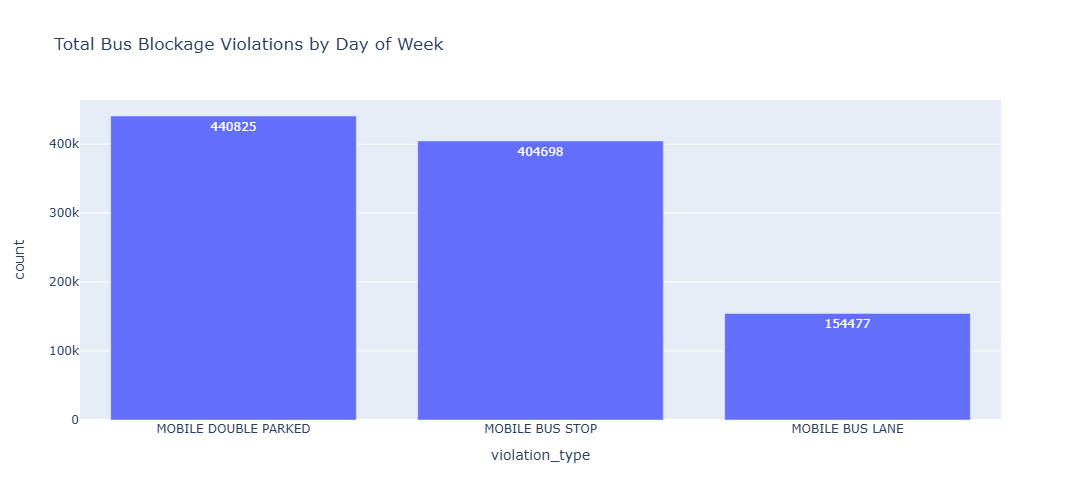

In [180]:
fig = px.bar(
    violation_type_df,
    x="violation_type",
    y="count",
    title="Total Bus Blockage Violations by Day of Week",
    text="count"
)

fig.update_traces(textposition="inside")  # show counts on top
fig.update_layout(height=500)  # increase figure height

fig.show()


**Trend analysis: daily/weekly/monthly counts**

In [168]:
# daily
daily_violations = pd.DataFrame()
daily_violations["date"] = df["first_occurrence"].dt.date
daily_violations["violation_id"] = df["violation_id"]
daily_violations["day_name"] = pd.to_datetime(daily_violations["date"]).dt.day_name()

In [169]:
daily_violations_count = daily_violations.groupby(["date","day_name"]).agg({"violation_id":"count"}).reset_index().rename({"violation_id":"violations"}, axis = 1)

In [170]:
daily_violations_count

,date,day_name,violations
0,2025-03-11,Tuesday,1
1,2025-03-15,Saturday,1
2,2025-03-24,Monday,5
3,2025-03-28,Friday,9
4,2025-03-29,Saturday,1
...,...,...,...
145,2025-08-17,Sunday,1098
146,2025-08-18,Monday,1920
147,2025-08-19,Tuesday,1802
148,2025-08-20,Wednesday,1082


In [171]:
# Aggregate by weekday
weekday_counts = (
    daily_violations_count.groupby("day_name")["violations"]
    .sum()
    .reindex(["Monday","Tuesday","Wednesday","Thursday","Friday","Saturday","Sunday"])  # order
    .reset_index()
)

In [172]:
weekday_counts

,day_name,violations
0,Monday,147702
1,Tuesday,159941
2,Wednesday,159663
3,Thursday,158316
4,Friday,163149
5,Saturday,114031
6,Sunday,97198


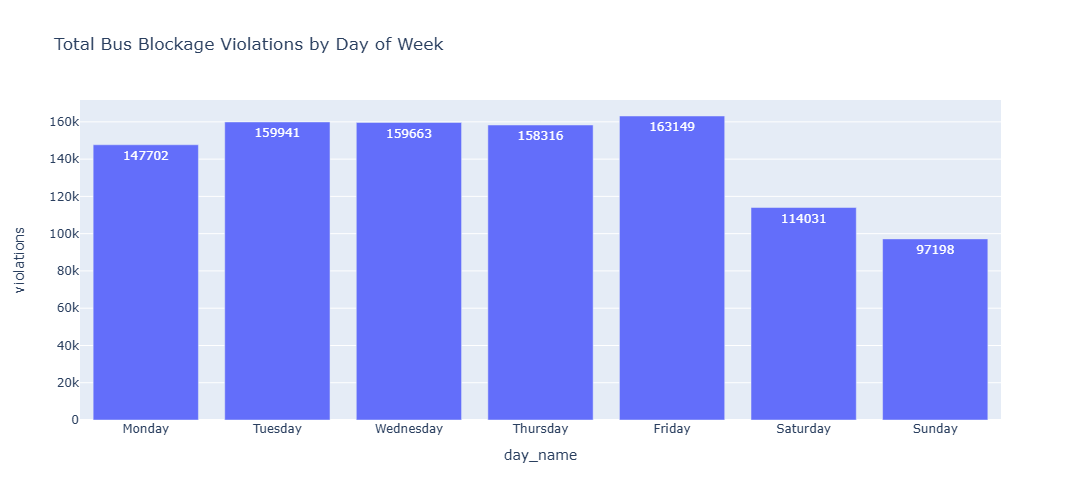

In [173]:
fig = px.bar(
    weekday_counts,
    x="day_name",
    y="violations",
    title="Total Bus Blockage Violations by Day of Week",
    text="violations"
)

fig.update_traces(textposition="inside")  # show counts on top
fig.update_layout(height=500)  # increase figure height

fig.show()


In [174]:
# monthly
monthly_violations = pd.DataFrame()
monthly_violations["month"] = df["first_occurrence"].dt.to_period("M") 
monthly_violations["violation_id"] = df["violation_id"]

In [175]:
monthly_violations_counts = monthly_violations.groupby("month").agg({"violation_id":"count"}).reset_index().rename(
{"violation_id":"violations"}, axis = 1)

In [178]:
monthly_violations_counts

,month,violations,month_start,month_name
0,2025-03,3601,2025-03-01,March 2025
1,2025-04,236249,2025-04-01,April 2025
2,2025-05,244138,2025-05-01,May 2025
3,2025-06,242007,2025-06-01,June 2025
4,2025-07,224459,2025-07-01,July 2025
5,2025-08,49546,2025-08-01,August 2025


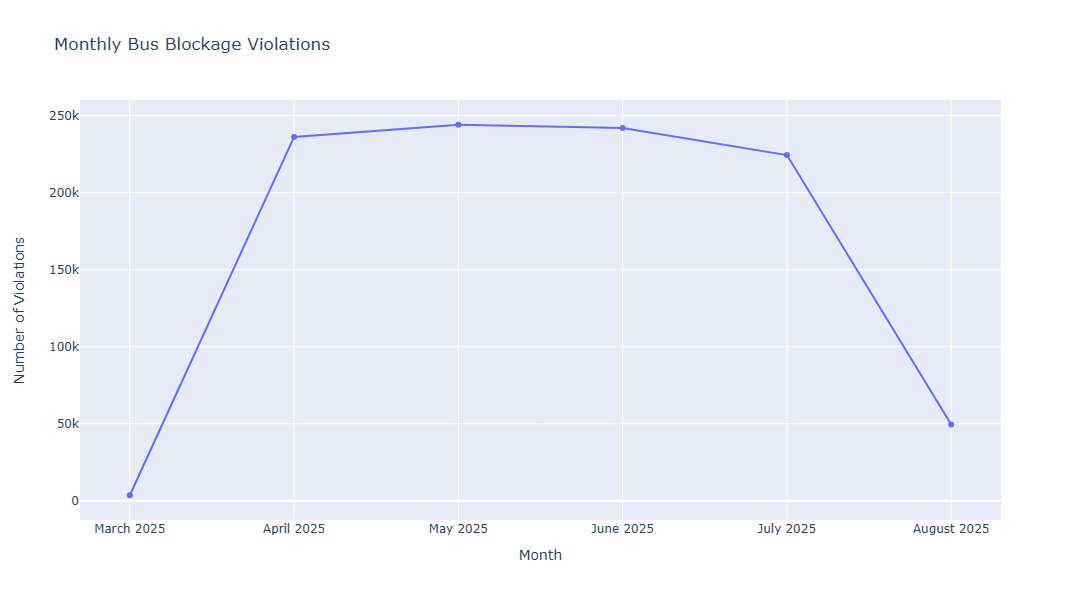

In [177]:
# Convert "month" Period to datetime for labels
monthly_violations_counts["month_start"] = monthly_violations_counts["month"].dt.to_timestamp()
monthly_violations_counts["month_name"] = monthly_violations_counts["month_start"].dt.strftime("%B %Y")

# Line chart
fig = px.line(
    monthly_violations_counts,
    x="month_name",
    y="violations",
    title="Monthly Bus Blockage Violations",
    markers=True
)

fig.update_layout(
    xaxis_title="Month",
    yaxis_title="Number of Violations",
    height=600
)

fig.show()
